# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. Complete the required functions in `hw4.py` script only. This exercise is graded automatically, and only the `hw4.py` script is tested.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/), numpy and pandas only. **Do not import anything else.**
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes this notebook with the exercise number and your ID as the filename and the `hw4.py` script. For example: `hw4_123456789_987654321.ipynb` and `hw4.py` if you submitted in pairs and `hw4_123456789.ipynb` and `hw4.py` if you submitted the exercise alone.

# I have read and understood the instructions: 

In [10]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Function for ploting the decision boundaries of a model
def plot_decision_regions(X, y, classifier, resolution=0.01, title=""):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.title(title)
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    plt.show()

## Reading the data

In [12]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

In [13]:
def visualize_data(X, y, title_prefix=""):
    if title_prefix is None or title_prefix == "":
        title_prefix = ""
    else:
        title_prefix = f"{title_prefix} - "

    # prepare data
    classes = np.unique(y)
    X_1000 = X[:1000, :]
    y_1000 = y[:1000]

    # hist for first feature - first 1000 data points:
    plt.figure(figsize=(8, 5))

    for i in range(len(classes)):
        data = X_1000[y_1000 == classes[i]][:, 0]
        plt.hist(data, bins=20, alpha=0.5, label=['class={}'.format(i)])  # `density=False` would make counts

    plt.xlabel('x1 feature')
    plt.ylabel('Amount')
    plt.title(f'{title_prefix}histogram of first 1000 data points of each class')
    plt.grid()
    plt.legend()
    plt.show()

    # hist for first feature - all data points:
    plt.figure(figsize=(8, 5))

    for i in range(len(classes)):
        data = X[y == classes[i]][:, 0]
        plt.hist(data, bins=20, alpha=0.5, label=['class={}'.format(i)])  # `density=False` would make counts

    plt.xlabel('x1 feature')
    plt.ylabel('Amount')
    plt.title(f'{title_prefix}histogram of all data points of each class')
    plt.grid()
    plt.legend()
    plt.show()

    # scatter for both features - first 1000 data points:
    plt.figure(figsize=(8, 5))
    for i in range(len(classes)):
        data = X_1000[y_1000 == classes[i]]
        plt.scatter(data[:, 0], data[:, 1], label='class={}'.format(i))

    plt.title(f'{title_prefix}scatter plot for first 1000 data points of each class')
    plt.legend()
    plt.xlabel('x1 feature units')
    plt.ylabel('x2 feature units')
    plt.grid()
    plt.show()

    # scatter for both features - all data points:
    plt.figure(figsize=(8, 5))
    for i in range(len(classes)):
        data = X[y == classes[i]]
        plt.scatter(data[:, 0], data[:, 1], label='class={}'.format(i))

    plt.title(f'{title_prefix}scatter plot for all data points of each class')
    plt.legend()
    plt.xlabel('x1 feature units')
    plt.ylabel('x2 feature units')
    plt.grid()
    plt.legend()
    plt.show()


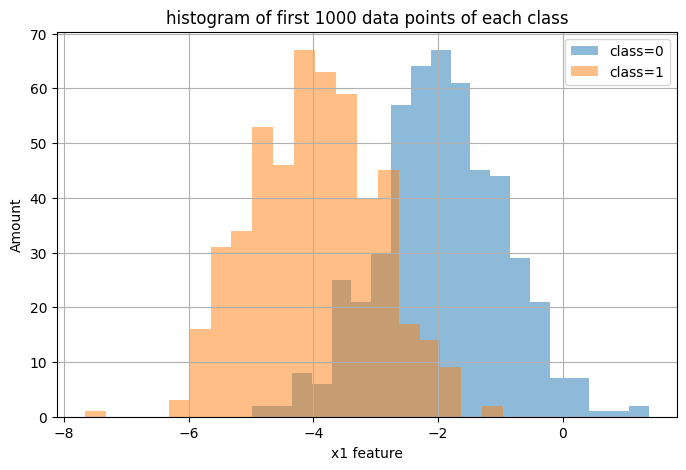

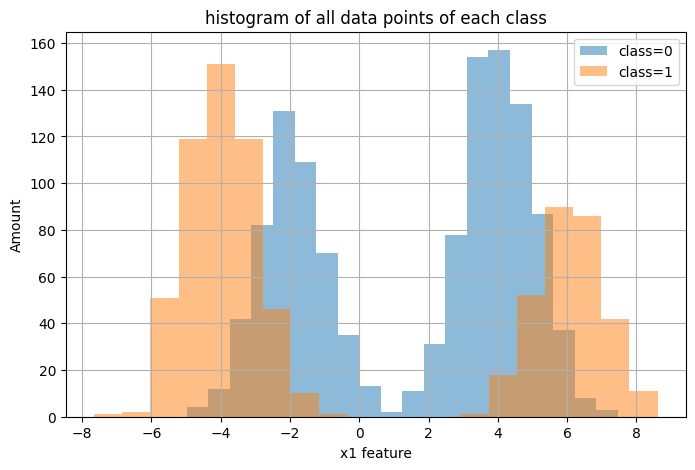

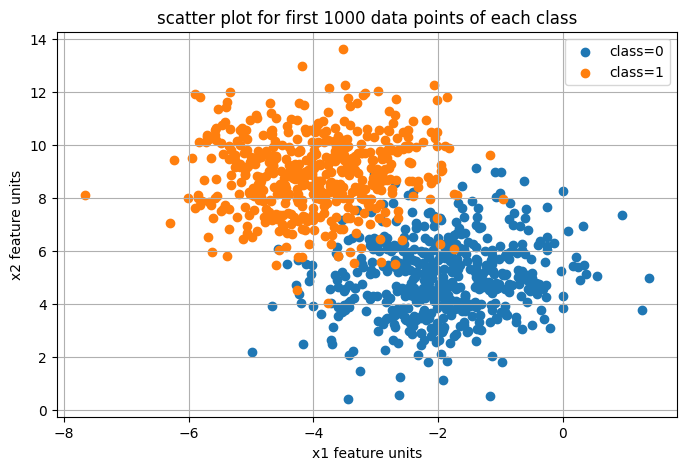

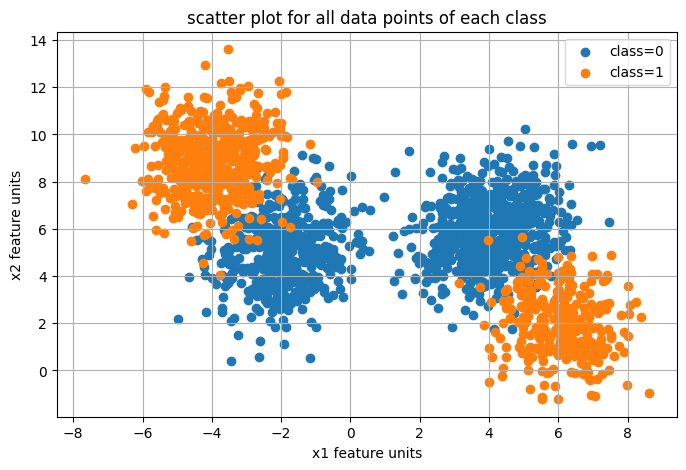

In [14]:
visualize_data(X_training, y_training)

## Logistic Regression (20 points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed
Your model should also store a list of the costs that you've calculated in each iteration

Open `hw4.py` and implement the `LogisticRegressionGD` class.

Note the following:
1. The `fit` method should train the model given the training data.
1. The `predict` method should provide predictions for given instances.
1. You can add as many auxiliary functions as you need. Only the above two functions will be tested.

In [15]:
from hw4 import LogisticRegressionGD

In [16]:
# test lor class on all the data
lor = LogisticRegressionGD()
lor.fit(X_training, y_training)

predictions_x_train = lor.predict(X_training)
predictions_x_test = lor.predict(X_test)


## Cross Validation (10 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Open `hw4.py` and implement the function `cross_validation`.

Note the following:
1. This function should not change the original data.
1. You should shuffle the data before splitting in order to get correct results.
1. You should return the average accuracy for each fold in order to compare models with different hyper-parameters.

Shuffle the training set before you split the data to the folds.

In [17]:
from hw4 import cross_validation

In [18]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
folds = 5

random_state = 1
acc_dict = {}
for eta in etas:
    for eps in epss:
        lor = LogisticRegressionGD(eta=eta, eps=eps, random_state=random_state)
        acc = cross_validation(X_training, y_training, folds, lor, random_state=random_state)
        acc_dict[(eta, eps)] = acc
        print(f"Accuracy with eta={eta}, eps={eps}:  {acc:.6f}")
    
best_params = max(acc_dict, key=acc_dict.get)
best_eta = best_params[0]
best_eps = best_params[1]

Accuracy with eta=0.05, eps=0.01:  0.321500
Accuracy with eta=0.05, eps=0.001:  0.321500
Accuracy with eta=0.05, eps=0.0001:  0.321500
Accuracy with eta=0.05, eps=1e-05:  0.321500
Accuracy with eta=0.05, eps=1e-06:  0.321500
Accuracy with eta=0.005, eps=0.01:  0.321500
Accuracy with eta=0.005, eps=0.001:  0.321500
Accuracy with eta=0.005, eps=0.0001:  0.321500
Accuracy with eta=0.005, eps=1e-05:  0.321500
Accuracy with eta=0.005, eps=1e-06:  0.321500
Accuracy with eta=0.0005, eps=0.01:  0.757000
Accuracy with eta=0.0005, eps=0.001:  0.823000
Accuracy with eta=0.0005, eps=0.0001:  0.828000
Accuracy with eta=0.0005, eps=1e-05:  0.824500
Accuracy with eta=0.0005, eps=1e-06:  0.821500
Accuracy with eta=5e-05, eps=0.01:  0.336500
Accuracy with eta=5e-05, eps=0.001:  0.657000
Accuracy with eta=5e-05, eps=0.0001:  0.821000
Accuracy with eta=5e-05, eps=1e-05:  0.828500
Accuracy with eta=5e-05, eps=1e-06:  0.824000
Accuracy with eta=5e-06, eps=0.01:  0.322000
Accuracy with eta=5e-06, eps=0.001:

In [19]:
print(f"Best learning rate (eta): {best_eta}")
print(f"Best epsilon: {best_eps}")

best_acc = acc_dict[best_params]
print(f"Accuracy with the best parameters: {best_acc:.4f}")

Best learning rate (eta): 5e-05
Best epsilon: 1e-05
Accuracy with the best parameters: 0.8285


### Normal distribution pdf (5 points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Open `hw4.py` and implement the function `norm_pdf`.

It might be a good idea to test your implementation in the next cell before you continue.

In [20]:
from hw4 import norm_pdf

## Expectation Maximization (15 points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

Open `hw4.py` and implement the class `EM`.

In [21]:
from hw4 import EM

In [22]:
em_obj = EM(k=2)
em_obj.fit(X_training[:, 0].reshape(-1, 1))

print(f"mus = {em_obj.get_dist_params()[1]}")
print(f"sigmas = {em_obj.get_dist_params()[2]}")
print(f"weights = {em_obj.get_dist_params()[0]}")

mus = [ 4.64077595 -2.96269627]
sigmas = [1.37523637 1.42195095]
weights = [0.50073236 0.49926764]


### GMM (5 points)

Open `hw4.py` and implement the function `gmm_pdf`.

It might be a good idea to test your implementation in the next cell before you continue.

In [23]:
from hw4 import gmm_pdf

## Naive Bayes (15 points)

Implement the Naive Bayes algorithm.

Calculate the likelihood using the EM algorithm you implemented above and find the distribution parameters. With these parameters you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Note the following:
1. The `fit` method should train the model given the training data.
1. The `predict` method should provide predictions for given instances.
1. You can add as many auxiliary functions as you need. Only the above two functions will be tested.

In [24]:
from hw4 import NaiveBayesGaussian

In [25]:
# test Naive Bayes
naive_bayes = NaiveBayesGaussian(k=2)
naive_bayes.fit(X_training, y_training)
predictions_x_train = naive_bayes.predict(X_training)
predictions_x_test = naive_bayes.predict(X_test)


In [26]:
#tests
print(np.sum(predictions_x_train))
print(np.mean(y_test==predictions_x_test))

783
0.902


## Model evaluation (15 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

In [27]:
from hw4 import model_evaluation

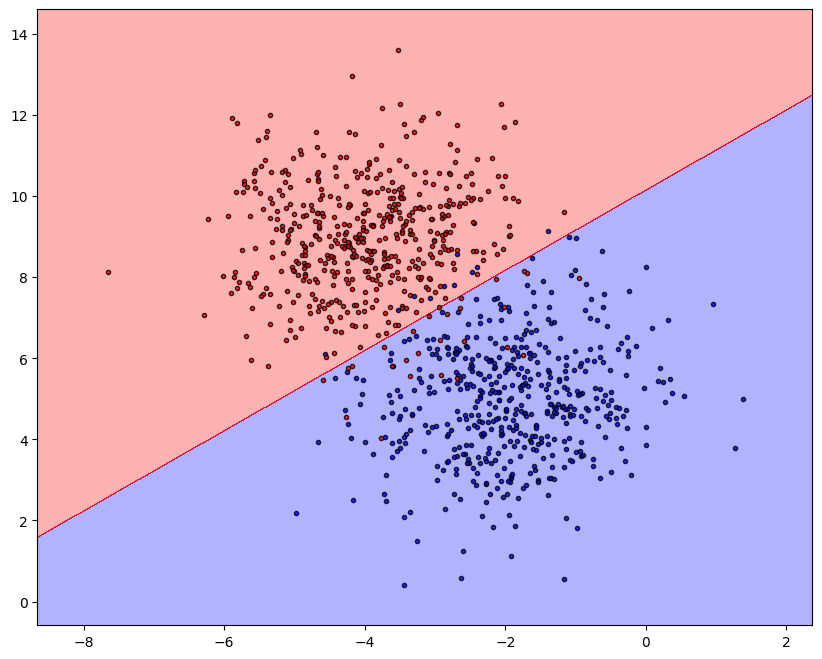

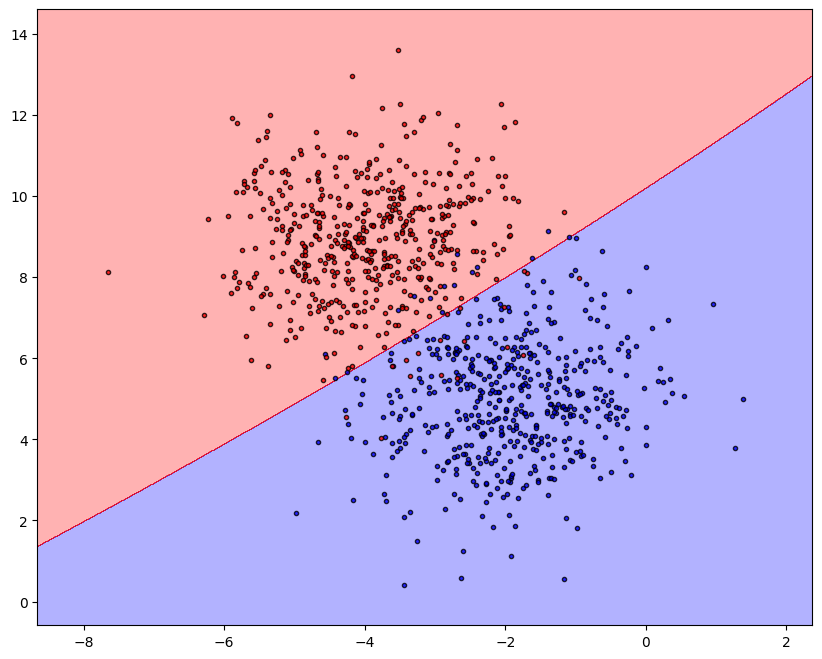

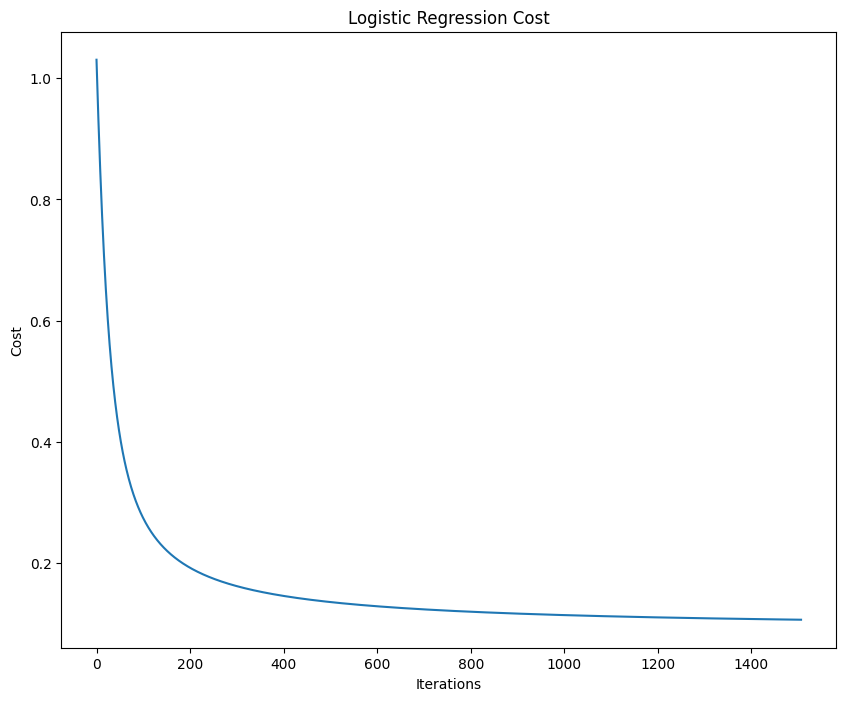

{'lor_train_acc': 0.965,
 'lor_test_acc': 0.94,
 'bayes_train_acc': 0.966,
 'bayes_test_acc': 0.942}

In [28]:
# Train - 1000, Test - 500
X_training_1000 = X_training[:1000, :]
y_training_1000 = y_training[:1000]

X_test_500 = X_test[:500, :]
y_test_500 = y_test[:500]

model_evaluation(X_training_1000, y_training_1000, X_test_500, y_test_500, 1, best_eps=best_eps, best_eta=best_eta)

##### As we can see in the first graph above the logistic regression model did a pretty good job. The boundary line divides the data to the 2 classes except for some outliers. The good result is due to the fact that the data is almost linearly seperable(except for some outliers).

##### As we can see in the second graph above the naive bayes model did a pretty good job. The model predicts the data accuarately to the 2 classes except for some outliers. The good result is due to the fact that the each class has 1 gaussian and the overlap (the reason for the mispredicted instances) between them is pretty small.

##### As we can see in the third graph above the graph is decreasing to arround 0.05, meaning there is an improvement in the number of errros the model does between itrtations. This is a good indication the training of the model works properly. 

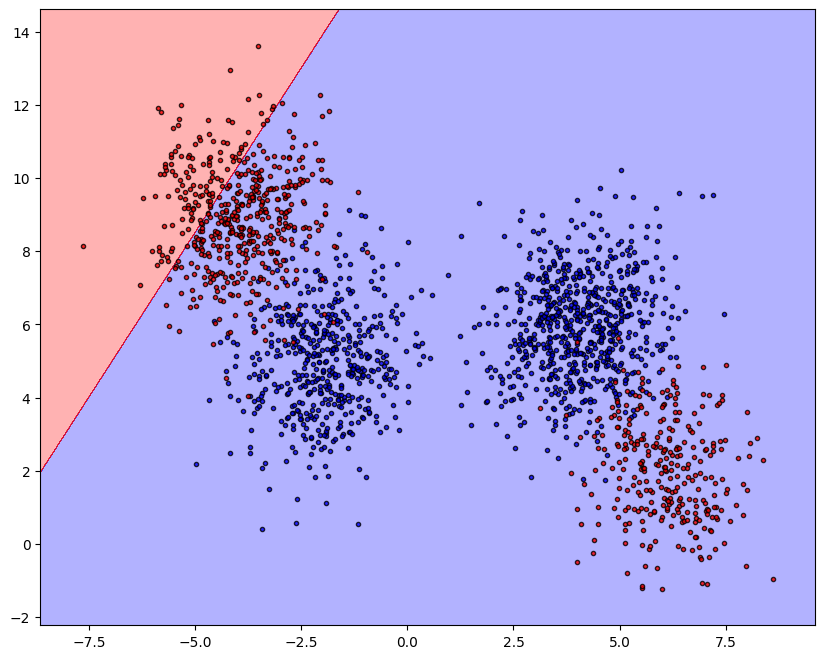

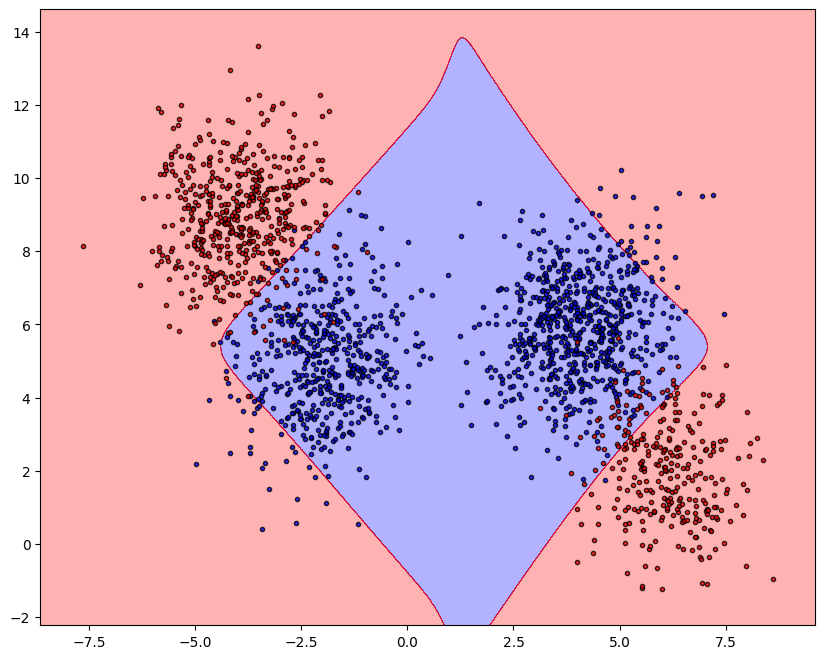

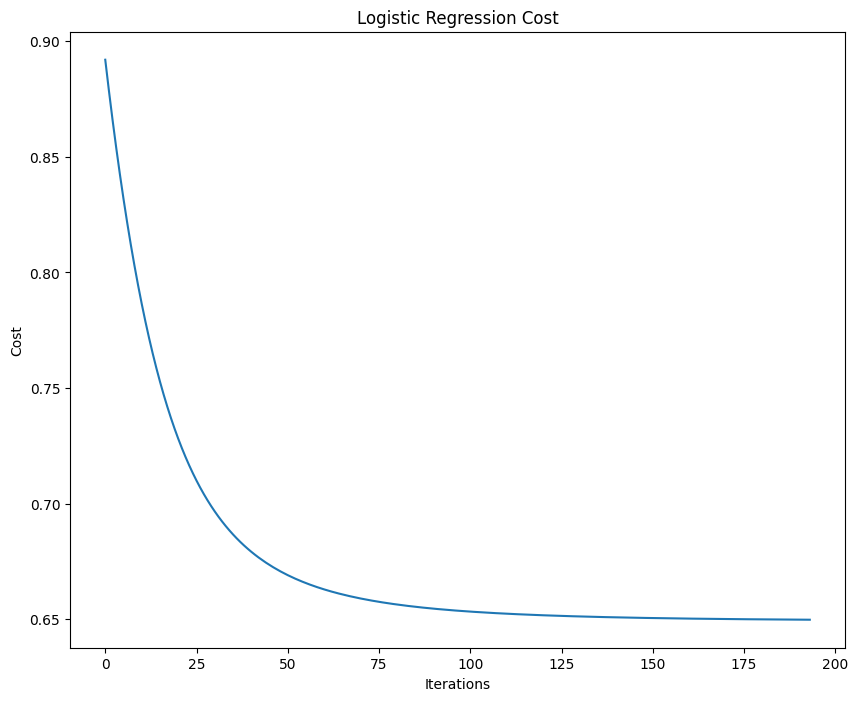

{'lor_train_acc': 0.8285,
 'lor_test_acc': 0.822,
 'bayes_train_acc': 0.9215,
 'bayes_test_acc': 0.902}

In [29]:
# Full Data
model_evaluation(X_training, y_training, X_test, y_test, 2, best_eps=best_eps, best_eta=best_eta)

##### As we can see in the first graph above, the logistic regression model did a bad job. The boundary line divides only the data points at the top left cornet to the 2 classes but it's wrong for all the red points in the right buttom. The bad result is due to the fact that the data is not  linearly seperable.

##### As we can see in the second graph above the naive bayes model did a pretty good job. The model predicts the data accuarately to the 2 classes except for some outliers. The good result is due to the fact that the each class has 2 gaussian and the overlap (the reason for the mispredicted instances) between gaussians from different calsses is pretty small.

##### As we can see in the second graph above, the graph is decreasing to arround 0.65, meaning there is an improvement in the number of errros the model does between itrtations. This is a good indication the training of the model works properly. But, as we can see it cannot decrease the cost rate below 0.65 and that's because of what we mentioned in the first paragraph.

## Open question (15 points)
1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset (`dataset_a`), in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) such that **Naive Bayes will work better on it when compared to Logisitc Regression**.
   2. Generate another dataset (`dataset_b`), in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) such that **Logistic Regression will work better on it when compared to Naive Bayes**.
   
2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

In [30]:
from hw4 import generate_datasets

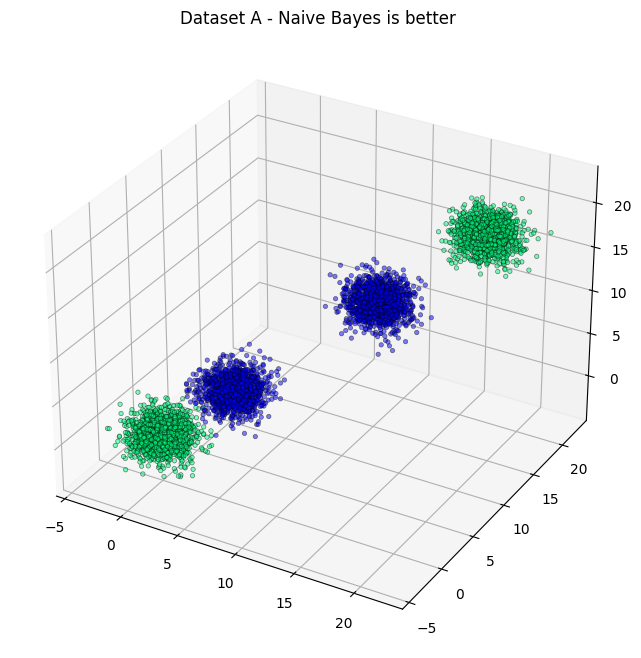

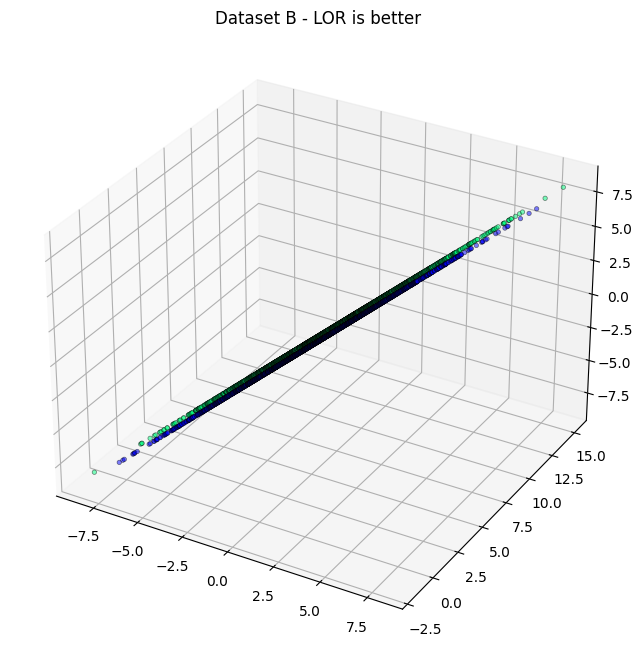

In [31]:
dataSets = generate_datasets()

In [32]:
def train_test(x , y):
    y= y.reshape(-1 , 1)
    training = np.concatenate((x,y) , axis = 1)
    np.random.shuffle(training)
    train = training[:int(len(training)*0.8)]
    test = training[int(len(training)*0.8):]
    x_train = train[:,:-1]
    y_train = train[:,-1]
    x_test = test[:,:-1]
    y_test = test[:,-1]
    
    return x_train, y_train, x_test, y_test


In [42]:
X_a = dataSets['dataset_a_features']
Y_a = dataSets['dataset_a_labels']
X_a_train, Y_a_train, X_a_test, Y_a_test = train_test(X_a, Y_a)
#print model evaluation
print("Model Evaluation for Dataset A:")
dataset_a_Accuaracies_Dict = model_evaluation(X_a_train, Y_a_train, X_a_test, Y_a_test, 4, best_eta, best_eps)
print(f"""
    logistic regression train acc: {dataset_a_Accuaracies_Dict['lor_train_acc']:.4f}
    logistic regression test acc: {dataset_a_Accuaracies_Dict['lor_test_acc']:.4f}
    naive bayes train acc: {dataset_a_Accuaracies_Dict['bayes_train_acc']:.4f}
    naive bayes test acc: {dataset_a_Accuaracies_Dict['bayes_test_acc']:.4f}

As we can see the naive bayes model is better than the naive bayes model

""")

X_b = dataSets['dataset_b_features']
Y_b = dataSets['dataset_b_labels']
X_b_train, Y_b_train, X_b_test, Y_b_test = train_test(X_b, Y_b)
#print model evaluation
print("Model Evaluation for Dataset B:")
dataset_b_Accuaracies_Dict = model_evaluation(X_b_train, Y_b_train, X_b_test, Y_b_test, 2, best_eta, best_eps)
print(f"""
    logistic regression train acc: {dataset_b_Accuaracies_Dict['lor_train_acc']:.4f}
    logistic regression test acc: {dataset_b_Accuaracies_Dict['lor_test_acc']:.4f}
    naive bayes train acc: {dataset_b_Accuaracies_Dict['bayes_train_acc']:.4f}
    naive bayes test acc: {dataset_b_Accuaracies_Dict['bayes_test_acc']:.4f}
    
As we can see the logistic regression model is better than the logistic regression model""")




Model Evaluation for Dataset A:

    logistic regression train acc: 0.4993
    logistic regression test acc: 0.5030
    naive bayes train acc: 0.9995
    naive bayes test acc: 0.9990

As we can see the naive bayes model is better than the naive bayes model


Model Evaluation for Dataset B:

    logistic regression train acc: 1.0000
    logistic regression test acc: 1.0000
    naive bayes train acc: 0.6685
    naive bayes test acc: 0.6680
    
As we can see the logistic regression model is better than the logistic regression model
